## Problem Statement

Today we will explore a data set dedicated to the cost of treatment of different patients. The cost of treatment depends on many factors: diagnosis, type of clinic, city of residence, age and so on. We have no data on the diagnosis of patients. But we have other information that can help us to make a conclusion about the health of patients and practice regression analysis

## Content
### Columns

1. age: age of primary beneficiary

2. sex: insurance contractor gender, female, male

3. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
   objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

4. children: Number of children covered by health insurance / Number of dependents

5. smoker: Smoking

6. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

7. charges: Individual medical costs billed by health insurance



First, Import the data stored in SQL Database.
- make a odbc connection
- read as a pandas Dataframe

In [1]:
import pandas as pd
import pyodbc 
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-FV1I7CQ;'
                      "uid=SanketDatabase;pwd=patil")

cursor = conn.cursor()

df = pd.read_sql_query('Select * from [Medical Cost Regression].dbo.[insurance]',conn)

- Let's Look at the dataframe

In [2]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Initial plan for data exploration
- Overview the data
- check datatypes of the features
- check null values and take action
- Feature Engineering (One-hot-encoding, skewness check)
- Data Exploration (Visual Analysis)

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
print(df.shape)
print(df.columns.tolist())

(1338, 7)
['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


- We have 1338 customer data and 7 columns including target variable charges
- Now we should look at datatype for each column

In [5]:
print(df.dtypes)

age           int64
sex          object
bmi         float64
children     object
smoker       object
region       object
charges     float64
dtype: object


- check null values

In [6]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

A good day is when there is no "NaN"in the data :D Let's look at our data to understand something about it.



In [7]:
df.describe(include='object').T

,count,unique,top,freq
sex,1338,2,male,676
children,1338,6,0,574
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [8]:
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
age,47
sex,2
bmi,548
children,6
smoker,2
region,4
charges,1337


- Create a list of binary freatures

In [9]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['sex', 'smoker']

- Create a list of categorical freatures

In [10]:
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['children', 'region']

- check the unique levels in categorical features

In [11]:
[[i, list(df[i].unique())] for i in categorical_variables]

[['children', ['0', '1', '3', '2', '5', '4']],
 ['region', ['southwest', 'southeast', 'northwest', 'northeast']]]

- Discrete numbers , aka integers, can be used to represent both discrete numeric variables and ordinal variables.

In [12]:
ordinal_variables = ['children']

- convert catogorical features in numeric levels respectively

In [13]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder
lb, le = LabelBinarizer(), LabelEncoder()

In [14]:
for column in ordinal_variables:
    df[column] = le.fit_transform(df[column])

df[ordinal_variables].astype('category').describe()

,children
count,1338
unique,6
top,0
freq,574


In [15]:
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])

df[binary_variables].describe()

,sex,smoker
count,1338.000000,1338.000000
mean,0.505232,0.204783
std,0.500160,0.403694
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [16]:
categorical_variables = list(set(categorical_variables) - set(ordinal_variables))

In [17]:
df= pd.get_dummies(df, columns = categorical_variables, drop_first=True)
df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


- Create a list of Numeric freatures

In [18]:
numeric_variables = list(set(df.columns) - set(ordinal_variables) - set(categorical_variables) - set(binary_variables))
print(numeric_variables)

['region_southeast', 'age', 'bmi', 'charges', 'region_northwest', 'region_southwest']


- check the skewness of the Numerical features and target; charges

array([[<AxesSubplot:title={'center':'region_southeast'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'charges'}>],
       [<AxesSubplot:title={'center':'region_northwest'}>,
        <AxesSubplot:title={'center':'region_southwest'}>]], dtype=object)

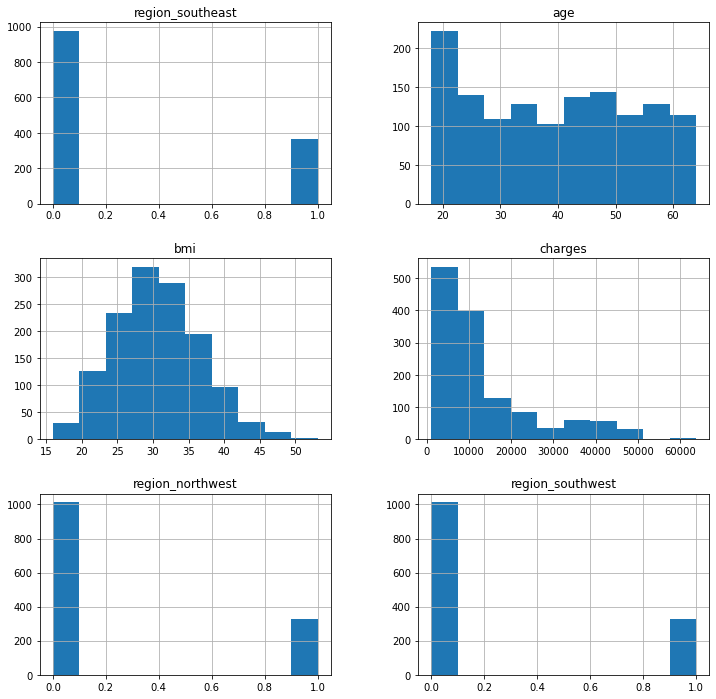

In [19]:
df[numeric_variables].hist(figsize=(12, 12))

In [20]:
from scipy.stats import skew 
for i in numeric_variables:
    print(i + " =", skew(df[i])) # log1p,sqrt,cbrt

region_southeast = 1.0244709894710085
age = 0.055610083072599126
bmi = 0.28372857291709386
charges = 1.5141797118745743
region_northwest = 1.1990630913597837
region_southwest = 1.1990630913597833


- age is near to the normal distribution
- bmi is skewed right skewed right, meaning that the right tail of the distribution is longer than the left
- Charges is positively skewed  

### Action plan
- for bmi perform square root transformation
- for charges perform Box-Cox target transformation

Skewness = 0.014147211230111848


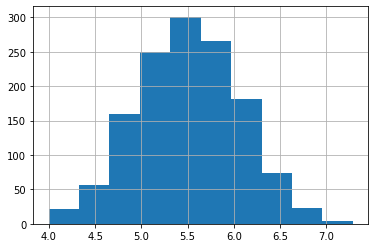

In [21]:
np.sqrt(df['bmi']).hist()
print("Skewness =",np.sqrt(df['bmi']).skew())

In [22]:
df['bmi']= np.sqrt(df['bmi'])

#### Target transformation
- The box cox transformation is a parametrized transformation that tries to get distributions "as close to a normal distribution as possible"

In [23]:
from scipy.stats import boxcox
bc_result = boxcox(df.charges)
boxcox_charges = bc_result[0]
lam = bc_result[1]
lam

0.043649053770664956

(array([ 64.,  97., 113., 164., 221., 278., 135., 104., 115.,  47.]),
 array([ 8.21807622,  8.81841614,  9.41875606, 10.01909598, 10.6194359 ,
        11.21977582, 11.82011575, 12.42045567, 13.02079559, 13.62113551,
        14.22147543]),
 <BarContainer object of 10 artists>)

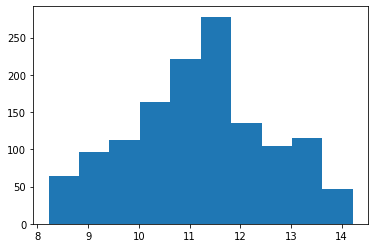

In [24]:
plt.hist(boxcox_charges)

- this target transformation method we will use in later stage of this notebook

# Visual Analytics
- plot corr heatmap 
- see age distribution in the dataset

<AxesSubplot:>

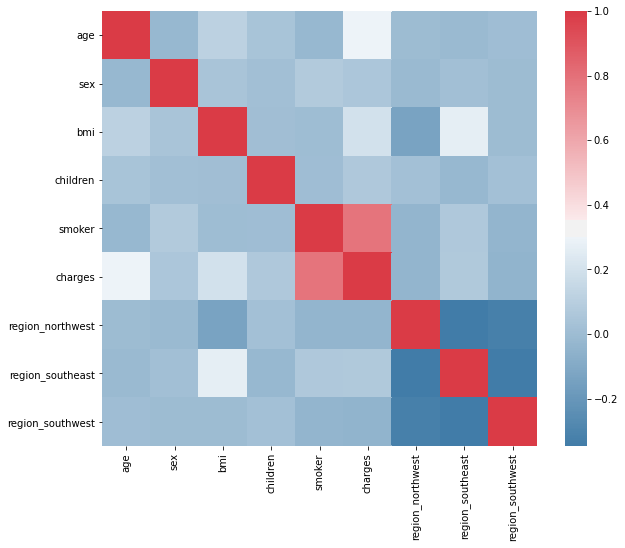

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

<AxesSubplot:title={'center':'Age Distribution'}, xlabel='age'>

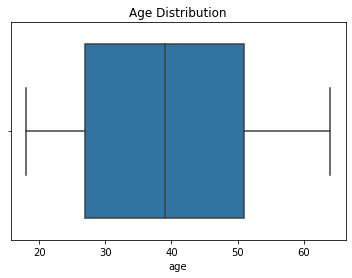

In [26]:
fig1, ax1 = plt.subplots()
ax1.set_title('Age Distribution')
sns.boxplot(df.age)

50% of people from this dataset have ages between 28-53
- A strong correlation is observed only with the fact of smoking the patient. Although, I expected a higher correlation with bmi; We investigate smoking in more detai

Male= 0


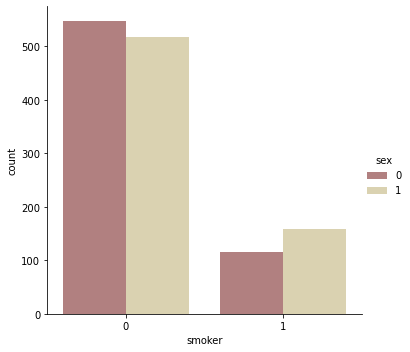

In [27]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="pink", data=df)
print("Male= 1")

- we can notice that more male smokers than women smokers
- lets see genderwise charges for smokers

<AxesSubplot:title={'center':'Box plot for charges of men'}, xlabel='charges', ylabel='smoker'>

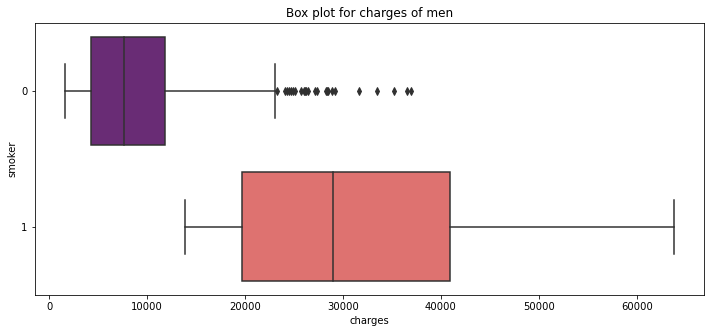

In [28]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of men")
sns.boxplot(y="smoker", x="charges", data =  df[(df.sex == 0)] , orient="h", palette = 'magma')

<AxesSubplot:title={'center':'Box plot for charges of women'}, xlabel='charges', ylabel='smoker'>

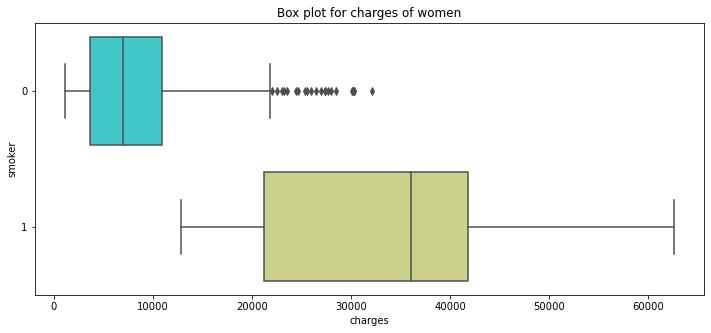

In [29]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  df[(df.sex == 1)] , orient="h", palette = 'rainbow')

- nonsmokers get less charges but smokers get high charges; female smokers charged more 
- Now see BMI, which I think would be important in this case

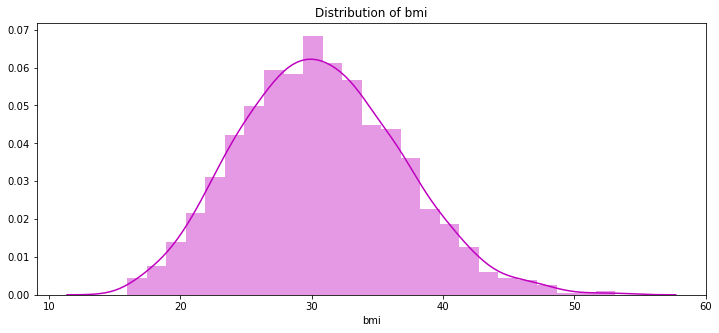

In [30]:
plt.figure(figsize=(12,5))
plt.title("Distribution of bmi")
ax = sns.distplot(df['bmi']**2, color = 'm') # squaring because we applied square transformation in EDA stage

- The average BMI in patients is 30. With a value equal to 30 starts obesity
- lets check charges to people who smoke and also have BMI more than 30

<Figure size 720x432 with 0 Axes>

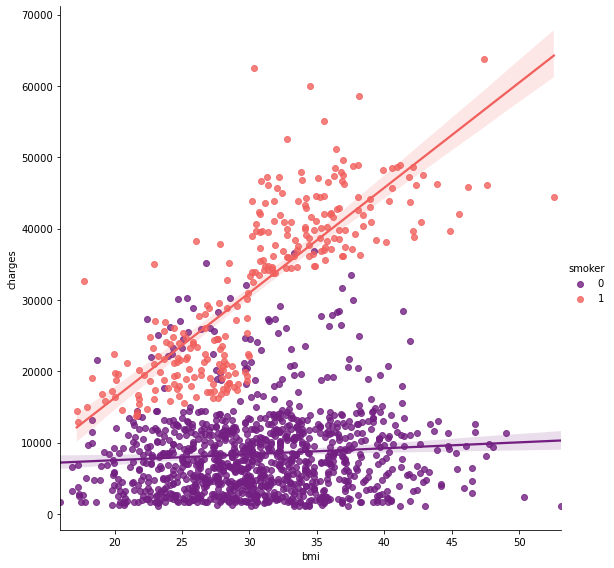

In [31]:
df2 =df.copy()
df2['bmi']= df2['bmi']**2
plt.figure(figsize=(10,6))
sns.lmplot(x='bmi', y="charges", hue="smoker", data=df2, palette = 'magma', height = 8)

- As expected people who smoke and also are obese have high charges; with increase in BMI greately increse charges
- Lastly see children i.e dependent on insurance 

42.9 % people have 0 children
24.22 % people have 1 children
17.94 % people have 2 children
11.73 % people have 3 children
1.87 % people have 4 children
1.35 % people have 5 children


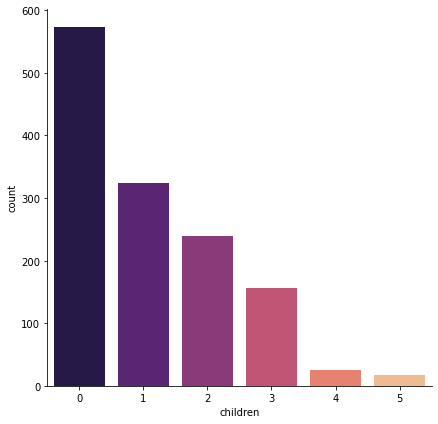

In [32]:
sns.catplot(x="children", kind="count", palette="magma", data=df, height = 6)
for i in (0,1,2,3,4,5):
    print(round(sum(df['children'] == i)/len(df)*100,2),"%" + " people have", i, "children")

<Figure size 720x432 with 0 Axes>

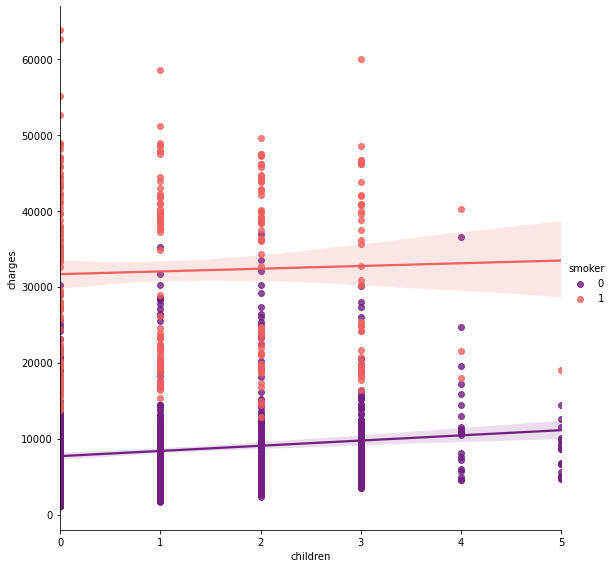

In [33]:
plt.figure(figsize=(10,6))
sns.lmplot(x='children', y="charges", hue="smoker", data=df, palette = 'magma', height = 8)

- It is pretty clear that smokers have high charges and people who have more than 1 child get high charges 

# Machine Learning Implementation
1. Polynomial Feature, target transformation and standardscaler 
2. Linear regression
2. Linear ridge regression 
3. Linear Lasso regression
4. Linear Elastic Net Regression 
5. RandomForest regression

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (PolynomialFeatures,StandardScaler, 
                                   PolynomialFeatures)
from sklearn.metrics import r2_score,mean_squared_error

- split the dataset and transform target by box-cox transformation

In [35]:
y, X = df['charges'], df.drop(columns='charges')
quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(x_quad, y, test_size=0.3, random_state=42)

In [36]:
bc_result2 = boxcox(y_train)
y_train_bc = bc_result2[0]
lam2 = bc_result2[1]
lam2

0.061262941323214304

### 1. linear regression 

- applying standard scaling
- train linear regression model
- make predictions

In [37]:
lr = LinearRegression()
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s= s.fit_transform(X_test)

In [38]:
lr=lr.fit(X_train_s, y_train_bc)
print(lr.coef_)

[-6.02067015e-17  1.18609319e+00 -2.60372971e-01  6.99345112e-01
  5.85427529e-01 -1.77635694e-01  1.01322218e-01  2.42557107e-02
  7.99133375e-03 -2.68593737e-01  1.58874832e-01 -2.28262058e-02
 -3.55701246e-01 -8.96401494e-01  1.04987984e-01  2.42894813e-01
  2.82945675e-01 -2.60372971e-01  2.47308263e-01 -6.42240292e-03
  4.76285719e-02  7.60714612e-02  6.33377224e-02  1.26133527e-03
 -6.43333556e-01  1.11279704e-01  2.33696229e+00 -4.02250796e-01
 -4.32444583e-01 -3.92235958e-01 -9.61798066e-02 -1.43921923e-01
 -9.57493213e-03 -1.39636102e-02 -6.20042098e-02 -1.77635694e-01
  1.33483694e-02  2.64661264e-02  7.80290503e-02  1.01322218e-01
  0.00000000e+00  0.00000000e+00  2.42557107e-02  0.00000000e+00
  7.99133375e-03]


In [39]:
y_pred_bc = lr.predict(X_test_s)

- Take inverse target transform as we want predictions in normal comparable units

In [40]:
from scipy.special import inv_boxcox
y_pred_tran = inv_boxcox(y_pred_bc,lam2)
r2_score(y_pred_tran,y_test)

0.8548992593040151

- linear regression without target transformation

In [41]:
lr = LinearRegression()
lr.fit(X_train_s,y_train)
lr_pred = lr.predict(X_test_s)
r2_score(lr_pred,y_test)

0.8368610554382401

- Now I can say the target transformation is helping the model to learn 
- lets plot the predictions; values on diagonal line are predicted with high accuracy

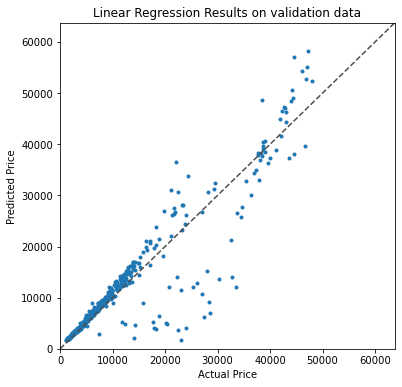

In [42]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test,y_pred_tran, 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results on validation data');

diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
x_lims = ax.get_xlim()
y_lims = ax.get_ylim()
diag_line.set_data(x_lims, y_lims)

### 2. Ridge regression

- Use Ridge CV to get best alpha value
- train model with the best aplha value
- inverse transform the predictions and check results

In [43]:
from sklearn.metrics import mean_squared_error
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [44]:
from sklearn.linear_model import RidgeCV

alphas = [0.06, 0.065]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

print(ridgeCV.alpha_, ridgeCV_rmse)

0.065 4537.838697582912


In [45]:
from sklearn.linear_model import Ridge, Lasso

In [46]:
rr = Ridge(alpha=0.065)
rr = rr.fit(X_train_s, y_train_bc)
Y_pred_rr = rr.predict(X_test_s)

In [47]:
from scipy.special import inv_boxcox
y_pred_tran = inv_boxcox(Y_pred_rr,lam2)
r2_score(y_pred_tran,y_test)

0.8547912725199049

In [48]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(y_test, y_pred_tran))

0.3651243061555203

- lets plot the predictions; values on diagonal line are predicted with high accuracy

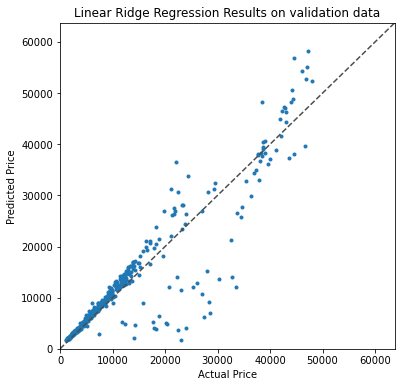

In [49]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test,y_pred_tran,marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Ridge Regression Results on validation data');

diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
x_lims = ax.get_xlim()
y_lims = ax.get_ylim()
diag_line.set_data(x_lims, y_lims)

### 3. Lasso regression

- Use Lasso CV to get best alpha value
- train model with the best aplha value
- inverse transform the predictions and check results

In [50]:
import warnings
warnings.filterwarnings('ignore', module='sklearn')
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_rmse) 

0.0005 4537.730558224809


In [51]:
lassor = Lasso(alpha=0.0005)
lassor = lassor.fit(X_train_s, y_train_bc)
Y_pred_lr = lassor.predict(X_test_s)

In [52]:
from scipy.special import inv_boxcox
y_pred_tran = inv_boxcox(Y_pred_lr,lam2)
r2_score(y_pred_tran,y_test)


0.8550587993360111

In [53]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(y_test, y_pred_tran))

0.36438631163962415

In [54]:
print('Of {} coefficients, {} are non-zero with Lasso.'.format(len(lassoCV.coef_), 
                                                               len(lassoCV.coef_.nonzero()[0])))

Of 45 coefficients, 41 are non-zero with Lasso.


- lets plot the predictions; values on diagonal line are predicted with high accuracy

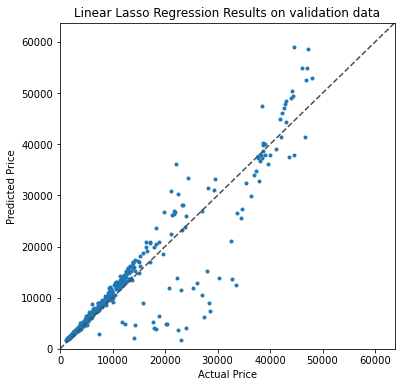

In [55]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test,y_pred_tran,marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Lasso Regression Results on validation data');

diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
x_lims = ax.get_xlim()
y_lims = ax.get_ylim()
diag_line.set_data(x_lims, y_lims)

### 4. Elastic Net regression

- Use ElasticNet CV to get best alpha value and L1 ratio
- train model with the best values
- inverse transform the predictions and check results

In [56]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)

0.0001 0.4 4537.763891764855


In [57]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.0001, l1_ratio = 0.4 )
ElasticNet = EN.fit(X_train_s, y_train_bc)
Y_pred_EN = ElasticNet.predict(X_test_s)

In [58]:
from scipy.special import inv_boxcox
y_pred_tran = inv_boxcox(Y_pred_EN,lam2)
r2_score(y_pred_tran,y_test)

0.8549043250798647

- lets plot the predictions; values on diagonal line are predicted with high accuracy

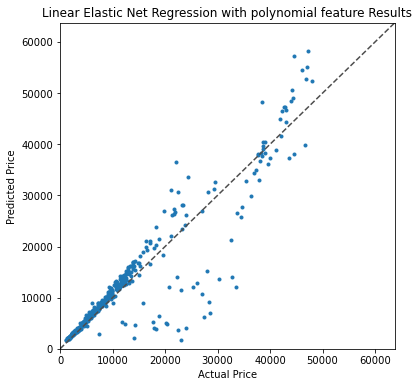

In [59]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test,y_pred_tran,marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Elastic Net Regression with polynomial feature Results');

diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
x_lims = ax.get_xlim()
y_lims = ax.get_ylim()
diag_line.set_data(x_lims, y_lims)

- As expected Lasso model made 4 coefficients zero making very good predictions in linear regression while ElasticNet model predictions were between Ridge and Lasso models

### 4. RandomForest regression

- RandomForest is a greedy algorithm and would generally prone to overfitting
1. Perform train Test Split with 30% data as a hold out set
2. train the model, make predictions
3. check mean squared error and R2 error to check results

In [60]:
y, X = df['charges'], df.drop(columns='charges')
X_train, X_test, y_train, y_test = train_test_split(x_quad, y, test_size=0.3, random_state=42)

In [61]:
from sklearn.ensemble import RandomForestRegressor



forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 42,
                              n_jobs = -1)
forest.fit(X_train,y_train)
forest_train_pred = forest.predict(X_train)
forest_test_pred = forest.predict(X_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train,forest_train_pred),
mean_squared_error(y_test,forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))

MSE train data: 3511593.854, MSE test data: 22318754.619
R2 train data: 0.976, R2 test data: 0.848


# Summary 

- AS Expected RandomForest overfitted on training set thus performed poor on validation set
- Lasso model made coefficients zero and performed very good for this data set

##### Lasso model predicted more accurately with good varience and Bias balance

### Suggestion for next steps

- Although the results I got are very good but to improve the results more and find the best model I must revisit the problem and apply more advanced methods such as clustering.

